# Stage 2: Pose Estimation (ICP)

## 1. Construct Lego from Training Set 
(using Unet segmentaiton mask)

### 1.1 See Lego from Unet Segmentation Mask

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


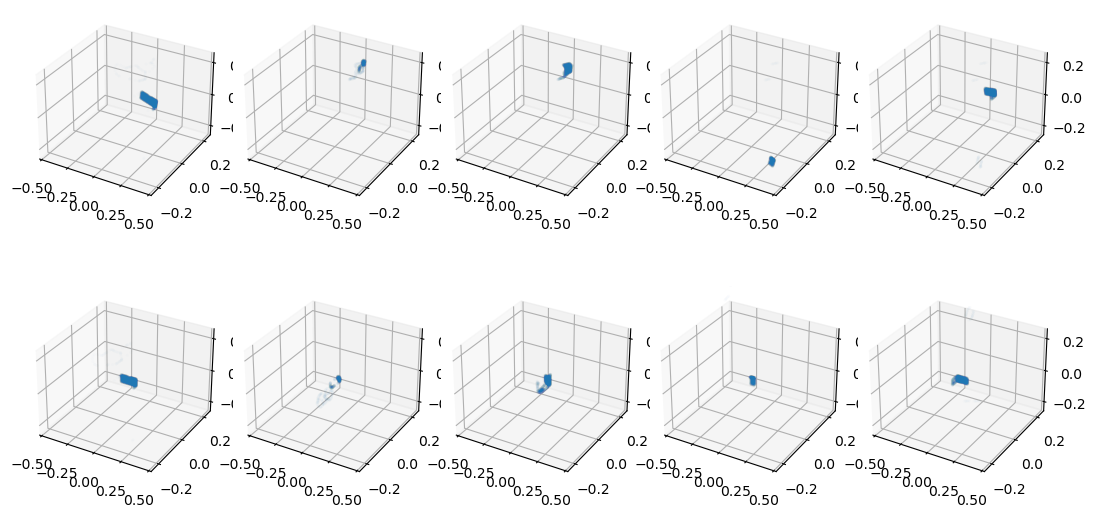

3909
	Rotation & translation errors (7.510963966159464e-05, 3.934136135194215e-11)
	Fitness: 1.0. RMSE: 1.7265453953742763e-10


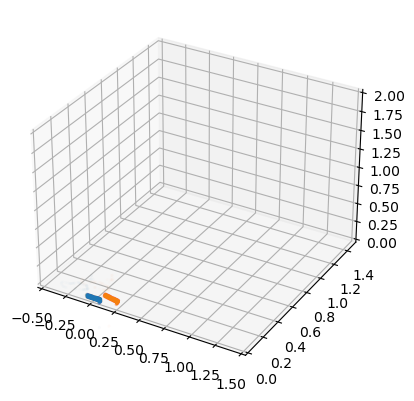

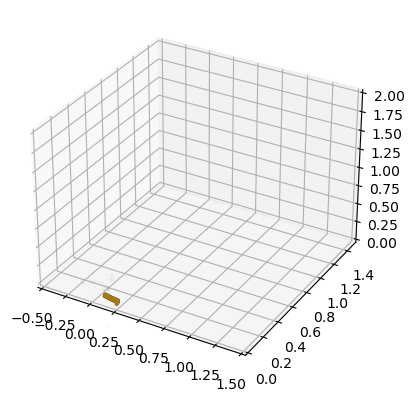

In [1]:
from utils.utils_data import *


device = torch.device('cpu')
params = {'bz': 1, 'shuffle': False, 'num_workers':1}
loader = get_loader(SegDataset(split_name='train', transforms=None), params=params)

sample = next(iter(loader))

rgb, depth, label, label_unet, meta, scene = \
    sample['rgb'], sample['depth'], sample['label'], sample['label_unet'], sample['meta'], sample['suffix']
meta = load_pickle(meta[0])


deflate = DeflateLabel()
label = deflate(label)
label_unet = deflate(label_unet)

rgb = rgb.squeeze().detach().numpy()
depth = depth.squeeze().detach().numpy()
label = label.squeeze().detach().numpy()
label_unet = label_unet.squeeze().detach().numpy()


''' 1. See legos produced by gt seg mask'''
# pcd_camera = img_to_camera(depth, rgb, meta['intrinsic'], view=False)   # (n,3)
# pcd_world = camera_to_world(pcd_camera, meta['extrinsic'])

# objects = crop_obj(pcd_world, label, meta, train=True)
# pcds = []
# for obj in objects:
#     pcd_world, pcd_canonical = obj[0], obj[1]
#     pcds.append(pcd_world); pcds.append(pcd_canonical)
# plot_pcds(pcds)


''' 2. See legos produced by Unet seg mask'''
pcd_camera = img_to_camera(depth, rgb, meta['intrinsic'], view=False)   # (n,3)
pcd_world = camera_to_world(pcd_camera, meta['extrinsic'])

objects = crop_obj(pcd_world, label_unet, meta, train=True)
pcds = []
for obj in objects:
    pcd_world, pcd_canonical = obj[0], obj[1]
    pcds.append(pcd_world); pcds.append(pcd_canonical)
plot_pcds(pcds)


''' 3. ICP on one object '''
for (obj_world, obj_canonical, pose, id, name) in objects:
    
    ''' Points in world vs. canonical frame before ICP'''
    obj_world, obj_canonical = pcd_to_o3d(obj_world), pcd_to_o3d(obj_canonical)
    
    print(len(obj_canonical.points))
    compare_points(obj_canonical, obj_world)

    ''' 2. Do ICP'''
    pose_gt = meta['poses_world'][id]
    # pose_pred = icp(obj_canonical, obj_world, verbose=False)  
    pose_pred, fitness, rmse = icp_o3d(obj_canonical, obj_world)  



    ''' 3. Points in world vs. canonical frame after ICP'''
    compare_points(obj_canonical, obj_world)

    print("\tRotation & translation errors", transformation_error(pose_gt, pose_pred))
    print(f"\tFitness: {fitness}. RMSE: {rmse}")

    break

### 1.2. Produce Legos Using Unet Mask

In [2]:
from utils.utils_data import *
from utils.utils_icp import *
import pickle


device = torch.device('cuda')
params = {'bz': 1, 'shuffle': False, 'num_workers':1}
loader = get_loader(SegDataset(split_name='train', transforms=None), params=params)


fname = './training_data/lego_poses_unet.pickle'
get_lego_poses(loader, fname=fname)


''' ---- Verify Result ---- '''
with open(fname, 'rb') as handle:
    OBJ_LEGO = pickle.load(handle)
keys = (list(OBJ_LEGO.keys()))
print(f"Number of keys: {len(keys)}. First 3 keys: {keys[:3]}")
print(f"(35, \"jenga\") has {len(OBJ_LEGO[(35, 'jenga')])} legos")
print(f"\t canonical pcds has shape resemble {OBJ_LEGO[(35, 'jenga')][0][0].shape}")
print(f"\t poses          has shape equals   {OBJ_LEGO[(35, 'jenga')][0][1].shape}")


Producing legos according to [unet] segmentation mask...


100%|██████████| 3964/3964 [53:40<00:00,  1.23it/s]


Number of keys: 23. First 3 keys: [(35, 'jenga'), (39, 'master_chef_can'), (48, 'potted_meat_can')]
(35, "jenga") has 1777 legos
	 canonical pcds has shape resemble (3909, 3)
	 poses          has shape equals   (4, 4)


### 1.3 Test ICP On 1 Scene

dict_keys(['rgb_files', 'depth_files', 'label_files', 'label_files_unet', 'meta_files', 'suffixes'])
Before ICP. Input shapes:  (720, 1280, 3) (720, 1280) (720, 1280) (720, 1280)
In icp_one_scene_leg. Shapes: rgb (720, 1280, 3), depth (720, 1280), label (720, 1280)
[['35' 'jenga']
 ['39' 'master_chef_can']
 ['48' 'potted_meat_can']
 ['51' 'pudding_box']
 ['58' 'wood_block']] Scene: None
In icp_one_scene_leg. Shapes: rgb (720, 1280, 3), depth (720, 1280), label (720, 1280)
[['35' 'jenga']
 ['39' 'master_chef_can']
 ['48' 'potted_meat_can']
 ['51' 'pudding_box']
 ['58' 'wood_block']] Scene: None


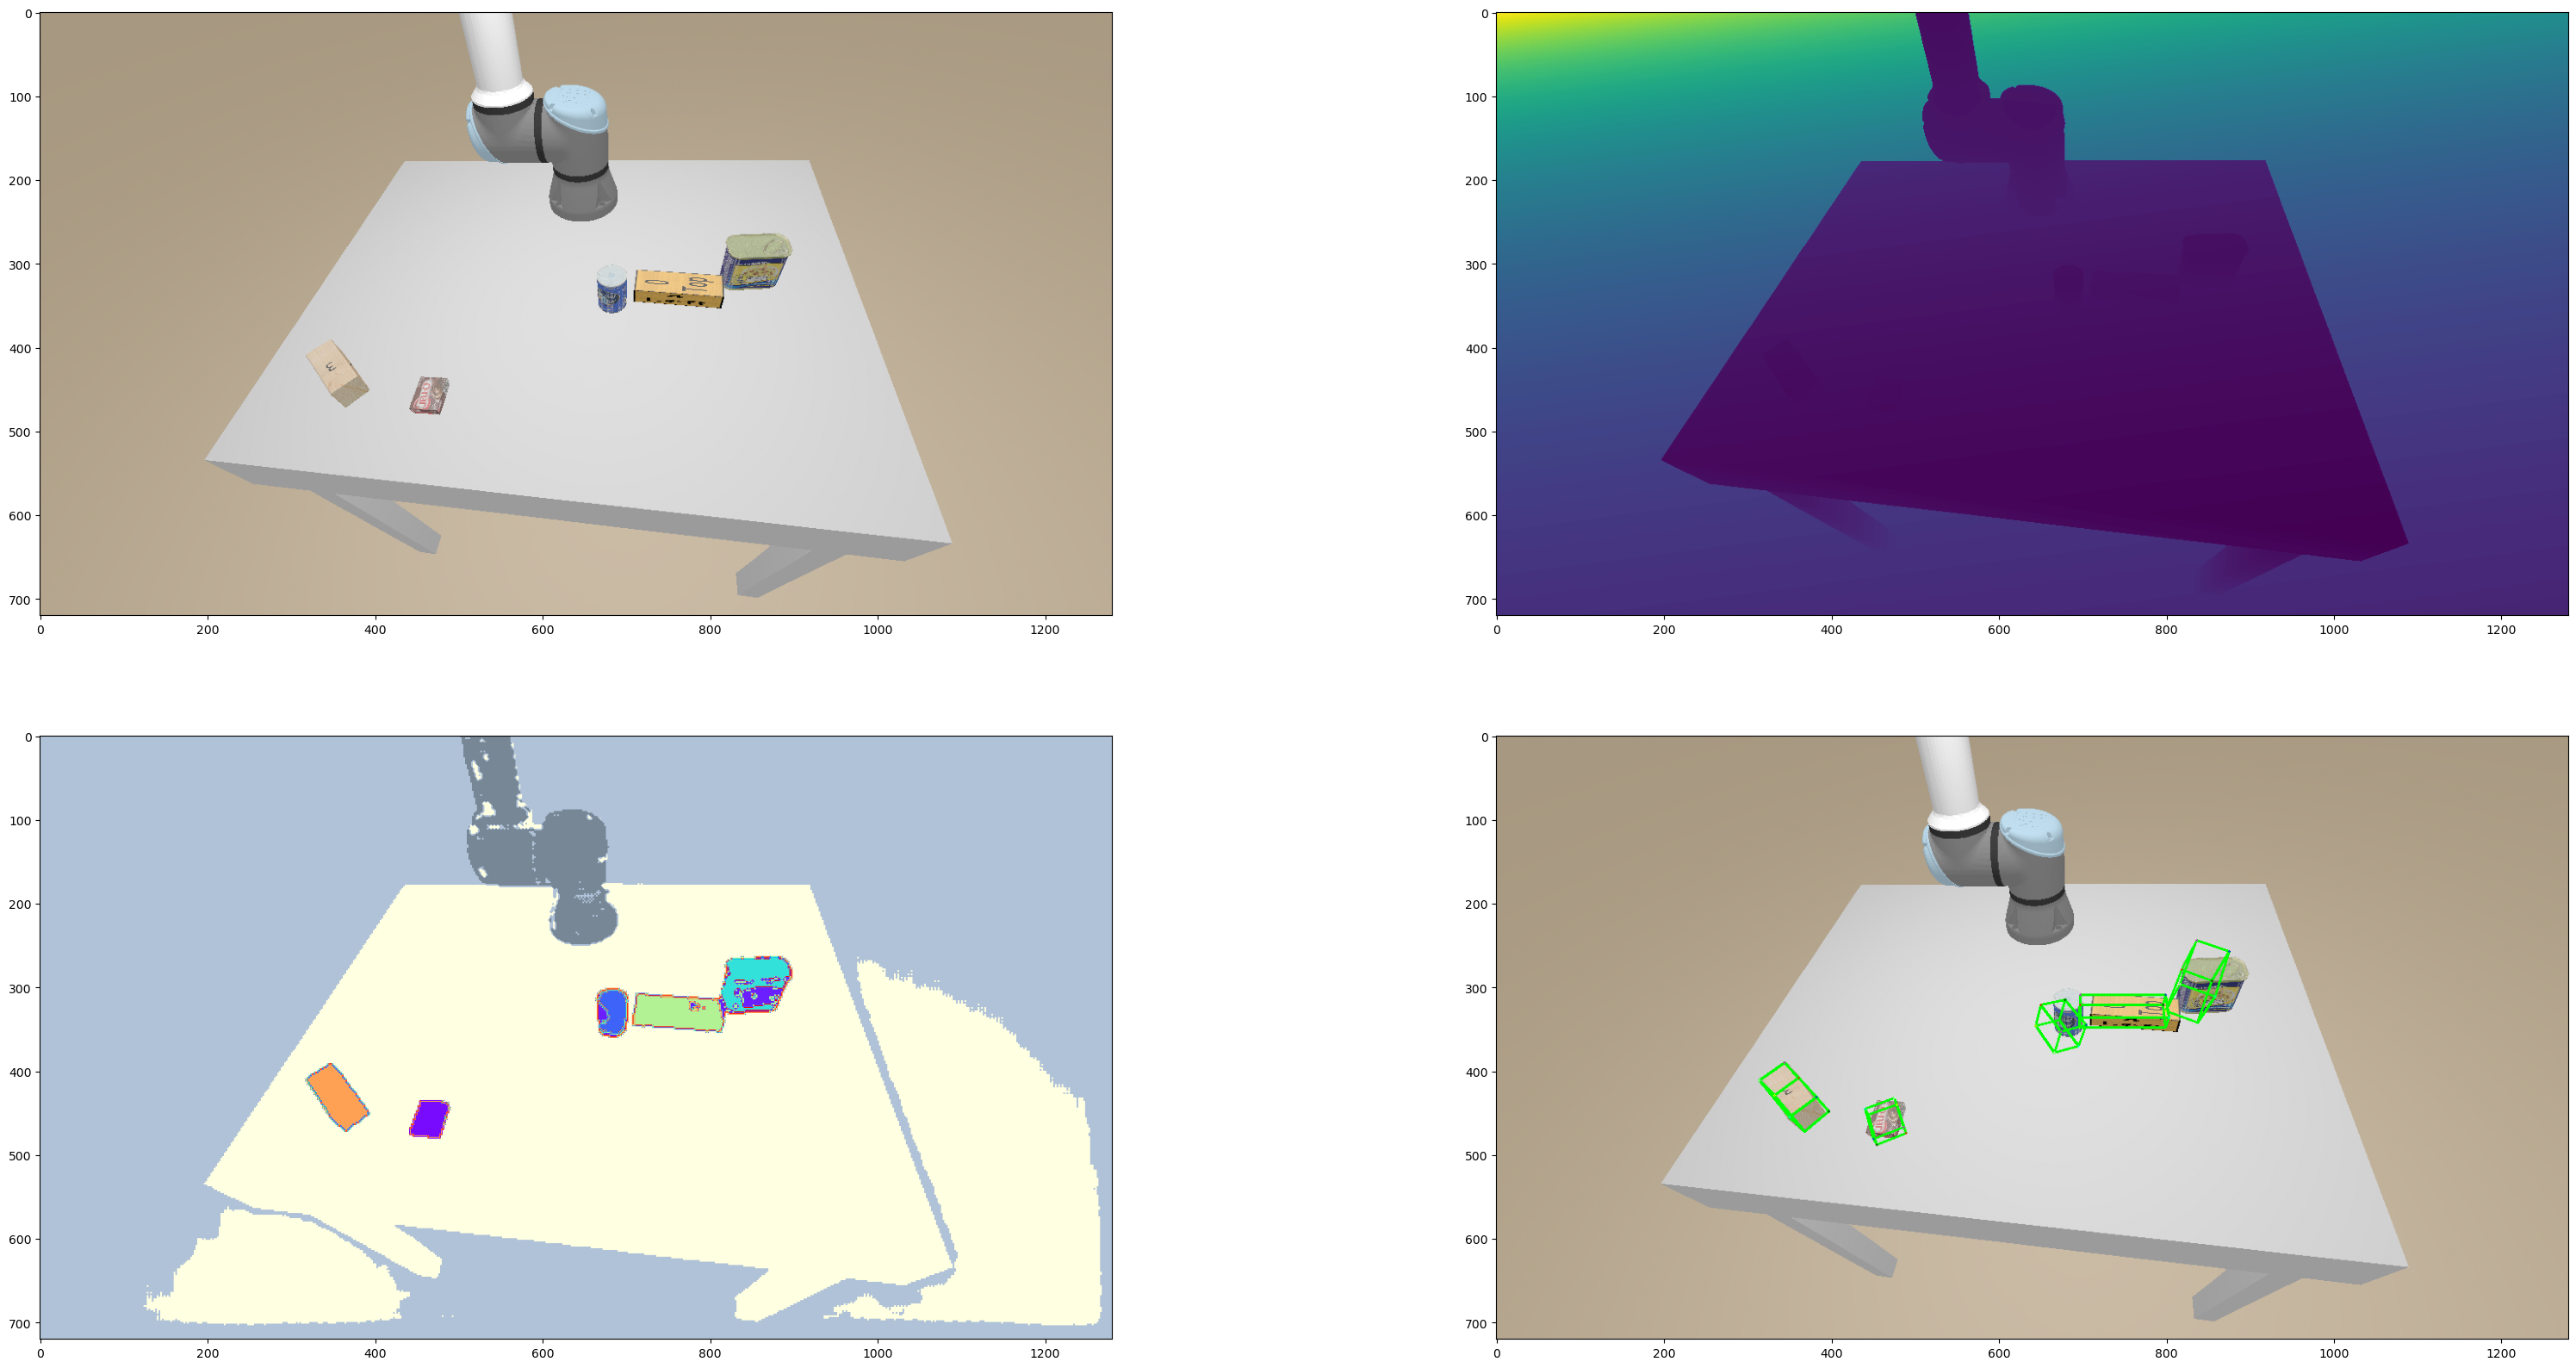

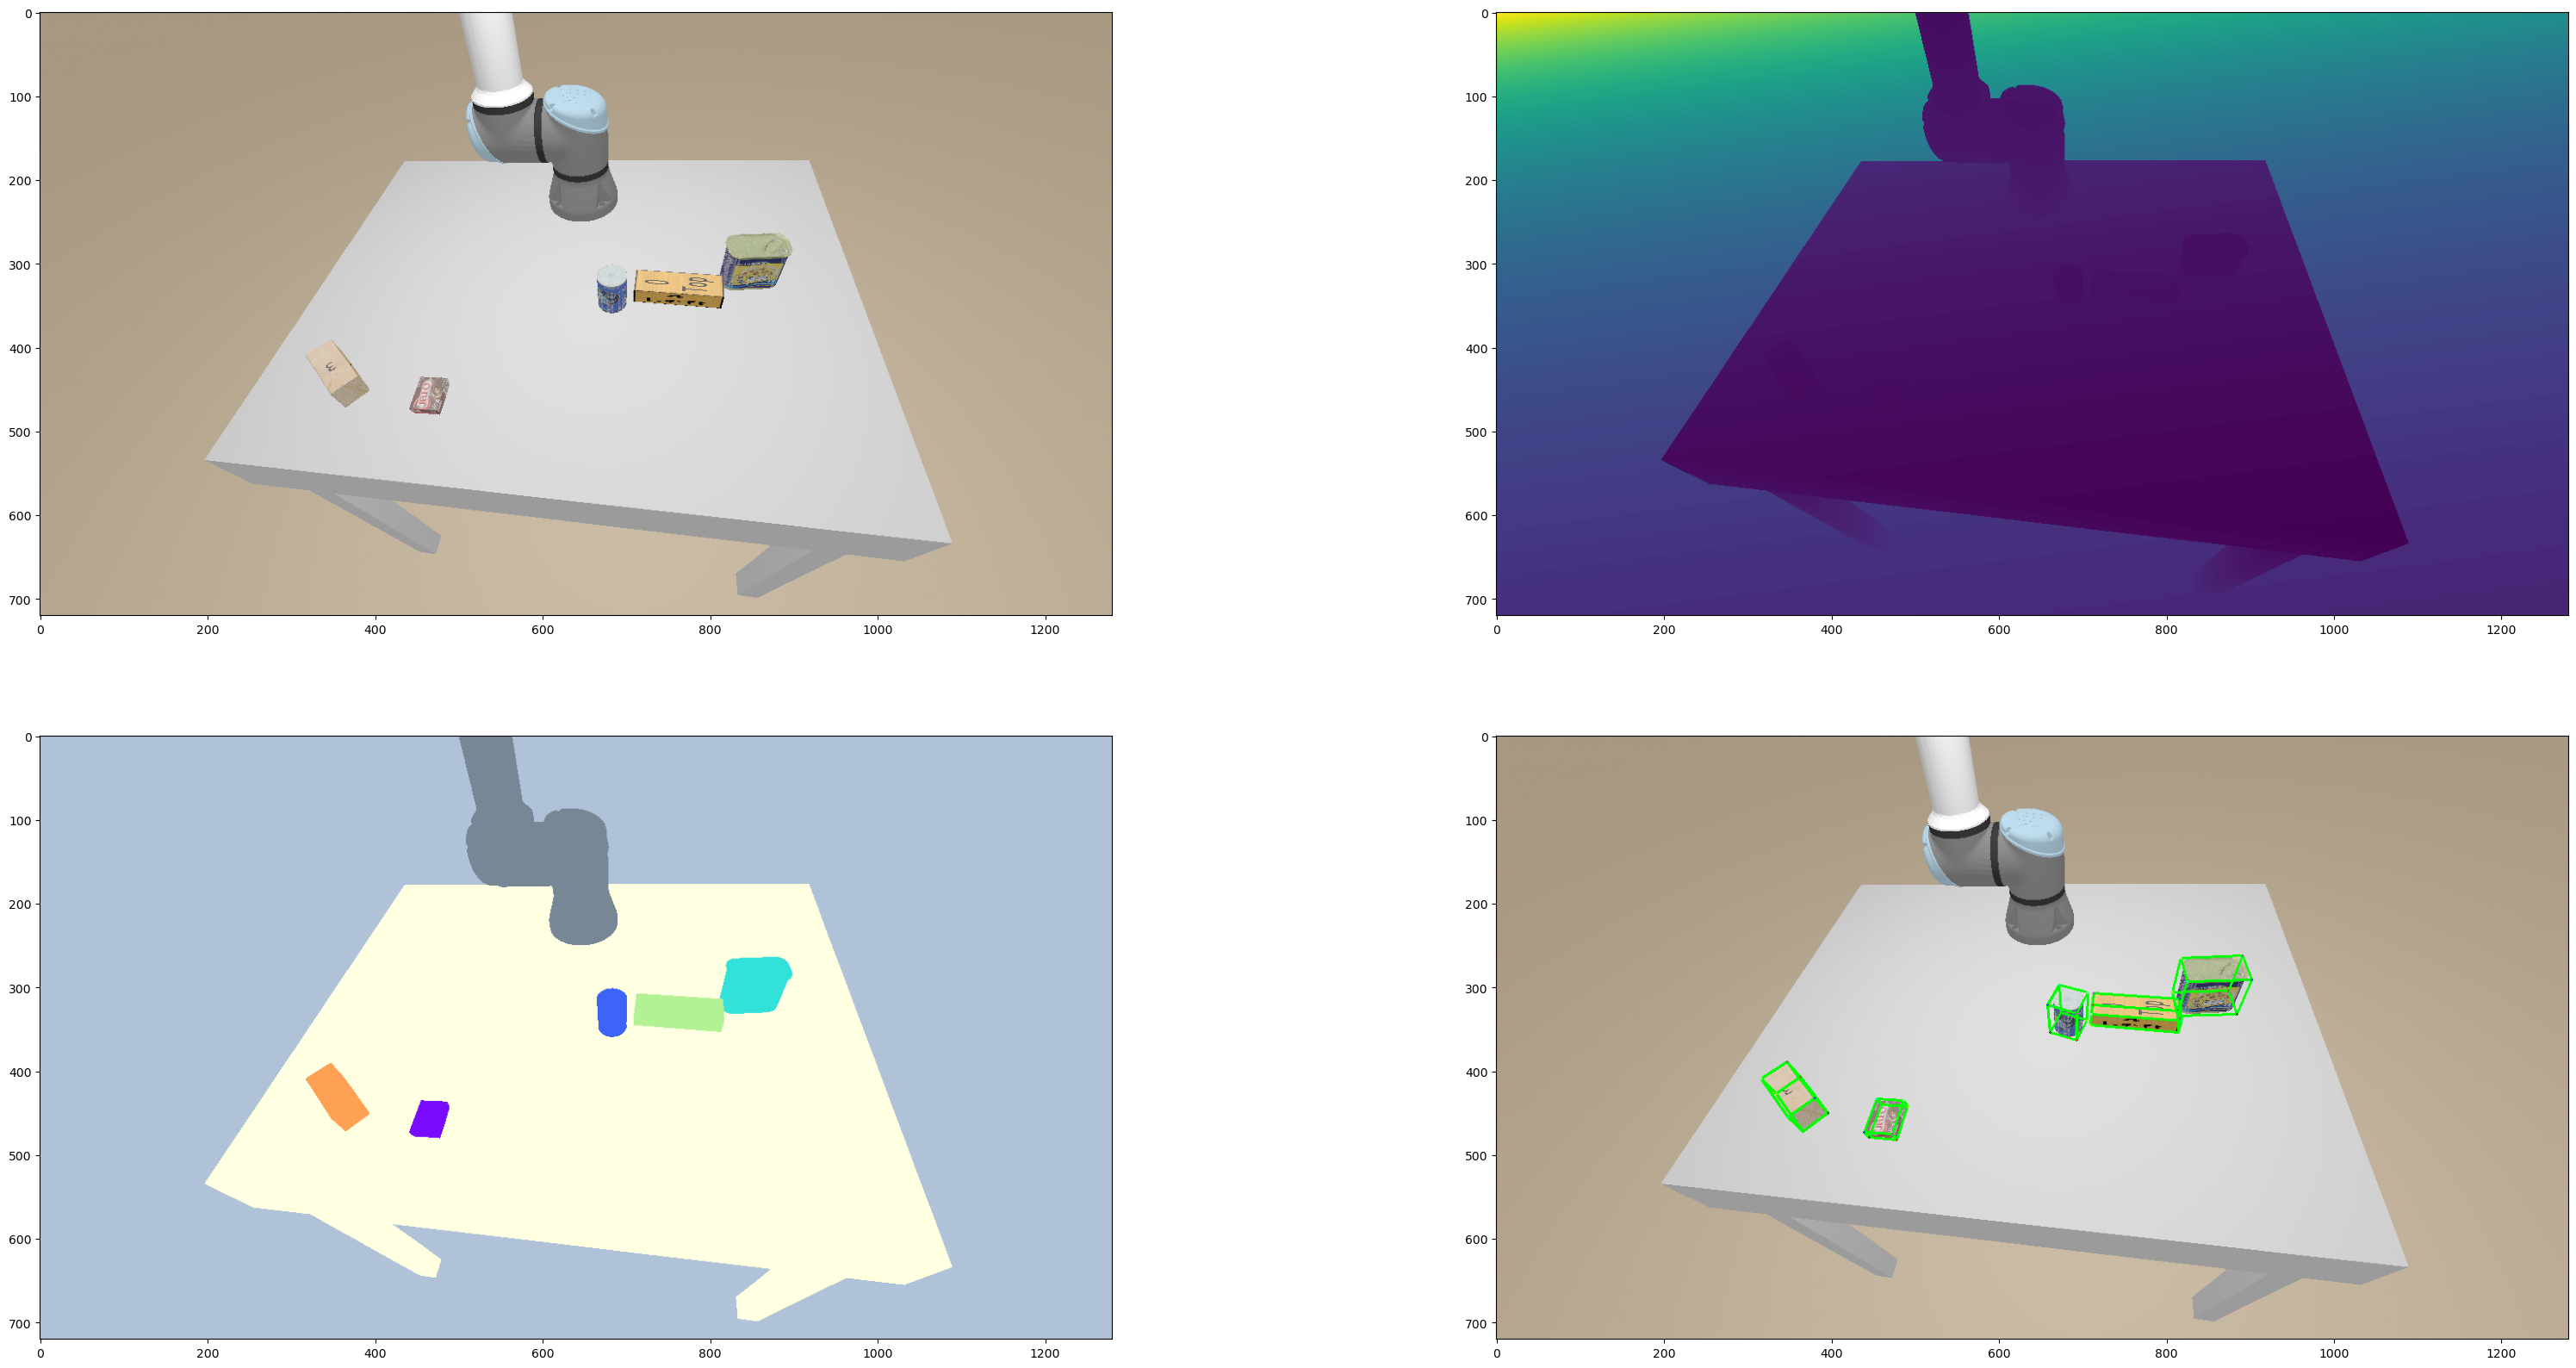

In [4]:
from utils.utils_data import *
from utils.utils_icp import *
import pickle


file_dict = get_split_files('val')

rgb, depth, label, label_unet, meta, scene = file_dict['rgb_files'], file_dict['depth_files'], \
    file_dict['label_files'], file_dict['label_files_unet'], file_dict['meta_files'], file_dict['suffixes']

idx = 15
rgb, depth, label, label_unet, meta = load_files(
    rgb[idx], depth[idx], label[idx], label_unet[idx], meta[idx]
)
print('Before ICP. Input shapes: ', rgb.shape, depth.shape, label.shape, label_unet.shape)



fname = './training_data/lego_poses_unet.pickle'
with open(fname, 'rb') as handle:
    OBJ_LEGO = pickle.load(handle)
pred = icp_one_scene_lego(OBJ_LEGO, rgb, depth, label_unet, meta, view=True)



fname = './training_data/lego_poses.pickle'
with open(fname, 'rb') as handle:
    OBJ_LEGO = pickle.load(handle)
pred = icp_one_scene_lego(OBJ_LEGO, rgb, depth, label, meta, view=True)

## 2. ICP on Val/Test Set

In [18]:
from utils.utils_icp import *
import pickle
from datetime import datetime
from benchmark_utils.benchmark import *

now = datetime.now().strftime("%d-%H:%M")
fname = f'./exp/val_icpo3d_{now}'

''' 1. Load object legos and poses '''
with open('./training_data/lego_poses_unet.pickle', 'rb') as handle:
    OBJ_LEGO = pickle.load(handle)

''' 2. ICP !!! '''

file_dict = get_split_files('val_tiny')
rgb, depth, label, label_unet, meta, scene = file_dict['rgb_files'], file_dict['depth_files'], \
    file_dict['label_files'], file_dict['label_files_unet'], file_dict['meta_files'], file_dict['suffixes']


vis_k = 0  # Visualize k-th scene result
preds = {}
with tqdm(total=len(rgb)) as pbar:
    for i,(_rgb, _depth, _label, _label_unet, _meta, _scene) in \
    enumerate(zip(rgb, depth, label_unet, label_unet, meta, scene)):

        # if i < vis_k: continue
        # if i > vis_k: break

        r, d, _, l, m = load_files(_rgb, _depth, _label, _label_unet, _meta)
        
        poses_world = icp_one_scene_lego(OBJ_LEGO, r, d, l, m, icp_thresh=1e-4)
        preds[_scene] = {"poses_world": poses_world}
        
        append_preds(preds, name=fname)
        pbar.update(1)

        ''' ---- See results --- '''
        # m['poses_world'] = poses_world
        # visualize_training_data(r, d, l, m)

gt_path = "./training_data/val_gt_tiny.json"
pred_path = f'{fname}.json'
val_gt_json = json.load(open(gt_path, "r"))
val_pred_json = json.load(open(pred_path, "r"))
eval_result, err_dict_all, headers, table = evaluate(val_gt_json, val_pred_json, level_ids=[1, 2])

print(eval_result)

100%|██████████| 15/15 [04:36<00:00, 18.43s/it]

{'level_1': {'rre': 72.59512768217758, 'rre_symmetry': 16.925813734585375, 'rte': 0.009517310848034711, 'pts_err': 0.017272466239187094, 'pose_acc_5deg_1cm': 0.16, 'pose_acc_10deg_1cm': 0.22666666666666666, 'pose_acc_10deg_2cm': 0.26666666666666666, 'pose_acc_15deg_2cm': 0.41333333333333333}, 'level_2': {'rre': nan, 'rre_symmetry': nan, 'rte': nan, 'pts_err': nan, 'pose_acc_5deg_1cm': nan, 'pose_acc_10deg_1cm': nan, 'pose_acc_10deg_2cm': nan, 'pose_acc_15deg_2cm': nan}, 'all': {'rre': 72.59512768217758, 'rre_symmetry': 16.925813734585375, 'rte': 0.009517310848034711, 'pts_err': 0.017272466239187094, 'pose_acc_5deg_1cm': 0.16, 'pose_acc_10deg_1cm': 0.22666666666666666, 'pose_acc_10deg_2cm': 0.26666666666666666, 'pose_acc_15deg_2cm': 0.41333333333333333}}



/home/kyle/Desktop/cse291.1_dl3d/cse291.1_hw3/benchmark_utils/benchmark.py:141: UserWarning: Please update your evaluation data with visibility annotation.
  warnings.warn('Please update your evaluation data with visibility annotation.')
/home/kyle/anaconda3/envs/open3d/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kyle/anaconda3/envs/open3d/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kyle/Desktop/cse291.1_dl3d/cse291.1_hw3/benchmark_utils/benchmark.py:252: RuntimeWarning: Mean of empty slice
  err_dict_overall[fieldname] = summarize_func(values)
/home/kyle/anaconda3/envs/open3d/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


## [Submission](https://storage1.ucsd.edu/cse291ibenchmark/benchmark3)